### <p style="text-align: right;"> &#9989; **Group 1 (GoGreen)** </p>
#### <p style="text-align: right;"> &#9989; Beth, Zhongjie, McKenna, Erik</p>

# Module 1



## How do SNPs relate to gene transcription?

We will work with maize. Last updated 2020/02/10

First, import the usual libraries
- `math`: basic math operations
- `os`: enable file manipulation with the OS
- `sys`: enable interaction with commandline
- `glob`: more variable manipulation
- `matplotlib.pyplot`: default plotter (I personally like ggplot waaaaay better. E)
    - `inline`: so that plots are shown in the notebook
- `seaborn`: nicer plots
- `numpy`: all number cruching done here
- `pandas`: data wrangling

In [2]:
import math  
import os   
import glob 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

Make sure to write the right path to the files. We will work here only with data (SNPs and FPKMs) found in chromosome 10. For example, __loading the full SNP matrix consumes about 16Gb!!!__ You may need even more to do some basic data wrangling. 

Assuming we don't have at least 32GB of RAM in our machine, we can simply load a fraction of the original data, found in the `sample_data` directory.

To handle the original raw data and its caveats, refer to the `data_loading.ipynb` notebook.

In [4]:
# Path to the folder where all the raw data is located
src = '/home/ejam/documents/css893/GoGreen/sample_data/'

# Path where we will save outputs
dst = '/home/ejam/documents/css893/output/'

# Matrix with imputed SNP data
# file_snp_imp = 'B73_plus_RTAs_snp_matrix_imputed/widiv_942g_979873SNPs_imputed_filteredGenos_withRTA_AGPv4.hmp.txt'
file_snp_imp = 'snp_imputed_chr10_sample.csv'

# Matrix with gene expression (FPKM)
# file_gen = '942_FPKM_B73_genes_w_feature.txt'
file_gen = 'gene_w_features_chr10.csv'

Now let's explore the expression data!!

We have 44259 rows × 947 columns in total.
- Rows: FPKM for the same gene across all 942 cultivars
- Columns: 5 columns of metadata + 942 cultivars

In [8]:
fpkm = pd.read_csv(src+file_gen)
fpkm

,gene,chromosome,feature_type,position_left,position_right,LH128,DKMBZA,CQ806,DKF274,Ill.Hy,...,NC328,NC326,PHV53,DKIBC2,A641,WIL900,Va22,E8501,PHP85,Oh43
0,Zm00001d024742,10,gene,85863323,85863746,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Zm00001d025653,10,gene,125107973,125113328,9.350780,9.954800,7.735490,10.360900,9.072890,...,4.685600,3.870230,5.278490,5.178290,3.802910,6.446750,5.618580,3.980550,4.175450,4.500850
2,Zm00001d024903,10,gene,93908316,93911235,0.954312,0.335773,0.689938,0.106595,0.200660,...,1.809510,1.671710,2.940510,1.523060,7.885560,4.522500,1.478990,9.566990,6.826610,0.509826
3,Zm00001d023618,10,gene,12298031,12300071,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Zm00001d024825,10,gene,89733155,89739279,0.857062,0.689824,0.613990,1.146330,1.137050,...,0.617702,0.317978,0.354413,0.412837,0.495563,0.312885,0.616760,0.450897,0.610228,0.472077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,Zm00001d023459,10,gene,6289475,6298739,7.743020,12.641800,10.975500,12.337900,15.497200,...,7.251110,13.711400,15.806400,16.518300,6.885620,22.863300,8.189910,6.772000,7.192290,10.332200
2983,Zm00001d026184,10,gene,140529821,140530718,0.437610,0.361114,0.366553,0.512719,0.149871,...,0.742883,0.587186,2.192500,0.110062,1.083900,1.572130,0.272518,0.154927,0.975337,0.605777
2984,Zm00001d024000,10,gene,35675291,35679293,38.797700,28.401200,3.048510,4.423800,8.698070,...,0.093581,2.816500,5.026650,3.186000,0.373411,18.871700,0.000000,0.000000,9.644770,33.329400
2985,Zm00001d025251,10,gene,111149588,111152196,0.081500,0.000000,0.068706,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.046316,0.062825,0.000000,0.000000,0.252784,0.000000,0.033119


FPKM can be easily converted to TPM by dividing each FPKM value by the sum of all FPKM values of the respective sample, and multiplying this by 1e6. This yields TPM

In [9]:
total_exp = fpkm.iloc[:, 5:].sum(axis='index')
tpm = fpkm.iloc[:, 5:]*1e6
tpm = tpm.div(other=total_exp, axis='columns')
tpm

,LH128,DKMBZA,CQ806,DKF274,Ill.Hy,LH162,DKWDAD1,H105W,L222,PHHB4,...,NC328,NC326,PHV53,DKIBC2,A641,WIL900,Va22,E8501,PHP85,Oh43
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,189.506595,261.983538,167.684262,253.040916,224.313529,275.336702,166.955091,187.486662,296.027161,198.988429,...,106.068226,79.385036,105.279689,113.680289,80.412785,143.121705,115.768295,84.420322,77.637823,90.144794
2,19.340463,8.836641,14.955968,2.603335,4.961016,27.759864,2.206053,2.291979,10.087266,14.960538,...,40.961993,34.289631,58.648587,33.436115,166.740691,100.402204,30.473919,202.898688,126.933177,10.210996
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,17.369556,18.154311,13.309624,27.996448,28.111847,16.584633,19.635756,17.736032,19.828836,19.988898,...,13.982960,6.522273,7.068781,9.063113,10.478713,6.946234,12.708060,9.562716,11.346507,9.454944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,156.923097,332.698145,237.918815,301.324549,383.144911,133.736242,171.979304,105.649796,343.939341,190.672884,...,164.143839,281.244261,315.259265,362.630351,145.596893,507.578931,168.749385,143.621966,133.732588,206.937364
2983,8.868777,9.503548,7.945866,12.521971,3.705335,20.414475,5.310212,13.227242,10.077015,0.000000,...,16.816690,12.044189,43.729498,2.416218,22.919138,34.902226,5.615110,3.285724,18.135301,12.132740
2984,786.289487,747.443129,66.083357,108.041039,215.046670,148.416419,159.188164,185.696017,1118.820979,881.939039,...,2.118395,57.771231,100.256731,69.943051,7.895800,418.963024,0.000000,0.000000,179.333710,667.534329
2985,1.651715,0.000000,1.489356,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.016784,1.328441,0.000000,0.000000,5.361095,0.000000,0.663318


Compute the z scores of a given dataframe. The data frame can be either FPKM or TPM values. Refer to Hart _et al._ "Finding the active genes in deep RNA-seq gene expression studies" _BMC Genomics_ 2013

In [10]:
def z_score_sample(sample, cutoff=2**-15, kernel='scott', num=1024):
    """
    Computes the Z-scores of a given sample (cultivar). 
    Do NOT use it directly but with the z_score function.
    
    Parameters
    ----------
    sample : array-like
        Expression levels of all genes of a fixed cultivar/individual
    
    cutoff : scalar
        Genes whose expression is lower than the cutoff value will be 
        considered as non-expressed
    
    kernel : str, callable
        bandwidth method for the Gaussian KDE. Look scipy.stats.gaussian_kde
        for more documentation.
    
    num : int
        Resolution to distinguish the mean of the KDE distribution
    
    Returns
    -------
    zFPKM : array-like
        Array with the z-scores of the sample
         
    mu : float
        Mean value from the fitted Gaussian distribution
         
    U : float
        Mean value of the expression levels above the 50% quantile
    
    sigma : float
        STD of the fitted Gaussian distribution
    
    """
    sample = sample[sample > cutoff]
    sample = np.log2(sample)
    kde = stats.gaussian_kde(sample)
    x = np.linspace(start=sample.min(), stop=sample.max(), num=num)
    y = kde(x)
    mu = x[np.argmax(y)]
    
    U = np.mean(sample[sample > mu])
    
    sigma = (U - mu) * math.sqrt(0.5*math.pi)
    
    zFPKM = (sample - mu) / sigma
    
    return zFPKM, mu, U, sigma

def z_score(df, skip=0, cutoff=-15, kernel='scott', num=1024):
    """
    df : dataframe
        Data frame containing gene expression values.
        Rows must be genes while columns are different individuals
    
    skip : scalar
        Number of metadata columns to skip from the beginning of the dataframe
    
    cutoff : scalar
        Genes with expression less than 2^cutoff will be considered nonexpressed
        
    kernel : str, callable
        bandwidth method for the Gaussian KDE. Look scipy.stats.gaussian_kde
        for more documentation.
    
    num : int
        Resolution to distinguish the mean of the KDE distribution
    
    Returns
    -------
    zcopy = dataframe
        A copy of the original dataframe with z-scores in place
    """
    
    zcopy = df.copy()
    for col in zcopy.columns[skip:]:
        z,mu,U,sigma = z_score_sample(df[col], cutoff=2**cutoff, kernel=kernel, num=num)
        zcopy[col] = cutoff
        zcopy.loc[z.index, col] = z
    return zcopy

Computing z-scores of TPMs

In [11]:
ztpm = z_score(tpm, skip=0)
ztpm

,LH128,DKMBZA,CQ806,DKF274,Ill.Hy,LH162,DKWDAD1,H105W,L222,PHHB4,...,NC328,NC326,PHV53,DKIBC2,A641,WIL900,Va22,E8501,PHP85,Oh43
0,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,...,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000
1,-0.019698,0.145338,-0.079922,0.145175,-0.002612,0.205236,-0.092319,0.006023,0.195782,-0.038335,...,-0.135560,-0.478592,-0.086041,-0.231162,-0.368779,-0.146139,-0.145117,-0.376134,-0.461432,-0.295281
2,-1.652013,-2.240051,-1.753161,-3.090374,-2.793503,-1.391991,-3.130046,-3.035679,-2.209044,-1.887243,...,-0.732920,-1.052815,-0.453762,-1.076138,0.107531,-0.388773,-1.024032,0.206532,-0.132983,-1.746453
3,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,...,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000
4,-1.728886,-1.733326,-1.833898,-1.411162,-1.523371,-1.750583,-1.595113,-1.622540,-1.728059,-1.680219,...,-1.407737,-2.188050,-1.783632,-1.977506,-1.699757,-2.216849,-1.599980,-1.823290,-1.746314,-1.797709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,-0.154639,0.313510,0.162273,0.268635,0.389408,-0.297465,-0.071502,-0.390103,0.302541,-0.068834,...,0.138597,0.386650,0.603304,0.569789,0.018967,0.720308,0.103022,-0.023054,-0.098119,0.258415
2983,-2.209650,-2.188845,-2.191004,-1.979970,-3.007199,-1.605948,-2.513287,-1.825113,-2.209768,-15.000000,...,-1.291878,-1.768492,-0.638258,-2.890325,-1.188596,-1.111955,-2.137827,-2.533125,-1.433001,-1.631554
2984,0.998003,0.883168,-0.724556,-0.456470,-0.033505,-0.224960,-0.125767,-0.000605,1.141991,1.025411,...,-2.592602,-0.695991,-0.116767,-0.566534,-1.884604,0.588989,-15.000000,-15.000000,0.097910,1.038770
2985,-3.411753,-15.000000,-3.350106,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,-15.000000,...,-15.000000,-15.000000,-15.000000,-3.487975,-3.048705,-15.000000,-15.000000,-2.207817,-15.000000,-3.568097


Compute the variance of the z-scores across all cultivars.

We select those genes whose variance is above 45. We choose the FPKM file because we will need position information of every highly varying gene.

In [15]:
var_cutoff = 45
ztpm['var'] = ztpm.var(axis='columns')
high_z = ztpm[ztpm['var'] > var_cutoff]
fpkm_high_z = fpkm.iloc[high_z.index]
fpkm_high_z

,gene,chromosome,feature_type,position_left,position_right,LH128,DKMBZA,CQ806,DKF274,Ill.Hy,...,NC328,NC326,PHV53,DKIBC2,A641,WIL900,Va22,E8501,PHP85,Oh43
25,Zm00001d026164,10,gene,140160680,140165357,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.00000,2.02605,0.000000e+00,1.479580,0.000000e+00,2.137120e-01,2.30052,0.000000,1.261760,0.00000
51,Zm00001d024806,10,gene,88824824,88833384,0.000000e+00,0.554836,9.232560e-01,0.000000e+00,0.000000,...,0.00000,0.00000,4.104290e-01,0.454788,9.397960e-01,0.000000e+00,0.00000,0.000000,0.000000,2.41799
63,Zm00001d023568,10,gene,10478273,10478636,1.219290e+00,0.000000,2.575210e-01,0.000000e+00,0.262541,...,7.63580,2.50381,2.338490e+00,2.374950,3.806500e+00,2.854170e+00,1.68669,0.493248,0.834913,6.37202
87,Zm00001d023672,10,gene,14661358,14662071,4.261410e-01,0.000000,5.501490e-02,0.000000e+00,0.000000,...,0.00000,0.00000,6.064910e-01,1.101600,0.000000e+00,2.180920e+00,0.00000,0.000000,0.000000,0.00000
94,Zm00001d024879,10,gene,91986119,91986476,1.916370e-01,0.153493,2.978850e-01,3.232600e-01,0.473546,...,1.58381,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,1.03533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,Zm00001d026498,10,gene,147196017,147196308,0.000000e+00,0.000000,0.000000e+00,1.830130e+00,0.953059,...,4.43933,7.91482,6.372110e+00,6.840940,7.600420e+00,1.058090e+01,3.38354,27.813100,4.262000,9.69275
2793,Zm00001d025350,10,gene,115137908,115138444,9.456680e-01,0.000000,2.576830e+00,0.000000e+00,1.026860,...,0.00000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.96650,2.787570,0.000000,0.00000
2811,Zm00001d023387,10,gene,4374701,4375148,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.135966,...,9.08571,9.57336,6.933320e+00,4.340270,1.296090e+01,5.493300e+00,1.80997,12.147400,40.581200,1.40593
2854,Zm00001d023145,10,lincRNA_gene,97217143,97218735,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.00000,1.79425,1.206460e+00,0.102832,0.000000e+00,0.000000e+00,1.02617,0.000000,2.142300,0.00000


Scatter plot of the variance of zTPMs across all cultivars. The red line is the chose cutoff.

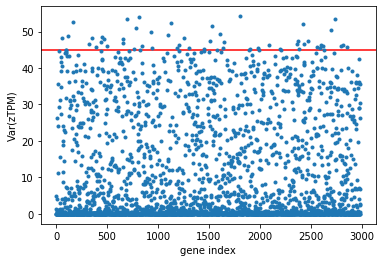

In [13]:
plt.xlabel('gene index')
plt.ylabel('Var(zTPM)')
plt.axhline(var_cutoff, c='r')
plt.plot(ztpm['var'], '.')

Sort the genes with high variance in expression according to their left position.

We assume that the gene regions do not overlap.

In [16]:
pos_sorted = fpkm_high_z.sort_values(by=['position_left'], ascending=True)
pos_sorted

,gene,chromosome,feature_type,position_left,position_right,LH128,DKMBZA,CQ806,DKF274,Ill.Hy,...,NC328,NC326,PHV53,DKIBC2,A641,WIL900,Va22,E8501,PHP85,Oh43
2152,Zm00001d023037,10,lincRNA_gene,1468122,1468421,0.000000,0.000000,1.646070,0.000000,0.000000,...,9.364700e-01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.888406,0.000000e+00,0.572567
1996,Zm00001d023269,10,gene,1698335,1698995,0.169234,0.139258,0.144124,0.419055,0.586715,...,1.582010e+00,2.270010,0.784611,1.402440e+00,0.841729,0.824034,2.172850e+00,1.446100,2.466200e+00,0.471220
725,Zm00001d023369,10,gene,4184043,4184730,0.000000,0.195099,0.327413,0.402576,0.224662,...,2.532550e-156,0.097942,0.000000,1.781820e-225,2.262020,0.540568,3.260170e-108,1.094880,3.171490e-11,0.671609
2811,Zm00001d023387,10,gene,4374701,4375148,0.000000,0.000000,0.000000,0.000000,0.135966,...,9.085710e+00,9.573360,6.933320,4.340270e+00,12.960900,5.493300,1.809970e+00,12.147400,4.058120e+01,1.405930
1651,Zm00001d023552,10,gene,9848877,9850164,8.663020,0.000000,0.000000,0.000000,6.460910,...,8.818520e+00,7.552350,0.112869,7.985050e+00,7.800830,16.247100,0.000000e+00,7.020660,0.000000e+00,0.010420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,Zm00001d026512,10,gene,147430705,147433738,0.000000,0.000000,0.000000,0.000000,0.207101,...,1.648530e-01,3.402500,1.326600,4.644510e+00,1.059820,0.000000,1.661630e+00,0.358003,6.092150e-01,0.355223
124,Zm00001d026595,10,gene,148673612,148674576,0.000000,0.159860,0.000000,0.000000,0.164642,...,3.517850e-01,1.010040,1.723580,2.704690e-01,0.000000,0.582016,6.596300e-01,0.923798,3.521210e-01,0.274990
2359,Zm00001d026602,10,gene,148755664,148756030,0.857194,0.620498,0.260648,0.557670,0.269863,...,0.000000e+00,0.000000,0.000000,4.032400e-01,0.000000,0.000000,2.974030e+00,0.000000,0.000000e+00,0.000000
1503,Zm00001d026620,10,gene,149083030,149083450,0.759084,0.000000,0.161200,0.000000,0.000000,...,1.206780e+00,0.956254,1.241530,6.878370e-01,1.607250,0.643809,1.987220e+00,0.329813,8.467640e-01,0.240613


Check for the left-most and right-most values of all gene regions.

In [17]:
start = pos_sorted.iloc[0]['position_left']
end = pos_sorted.iloc[-1]['position_right']
print(start, end)

1468122 149712786


__We now load the SNP information__ and select only those SNPs that happen in the highly varying genes.

In [5]:
snp_matrix_imputed = pd.read_csv(src + file_snp_imp, dtype={'chrom': int})
snp_matrix_imputed

,chrom,pos,764,779,787,790,793,904,911,912,...,YANG,YE_4,YE-CHI-HUNG,YELLOW_3-4,YING-55,Yong_28,Yu796_NS,ZS01250,ZS1791,ZS635
0,10,95800527,C,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C
1,10,95800923,G,A,A,A,G,A,A,A,...,G,A,A,A,A,A,A,G,G,G
2,10,95800952,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A
3,10,95800959,C,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C
4,10,95801220,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10,115203353,G,G,G,G,G,G,G,G,...,G,G,G,G,T,G,G,T,G,G
4996,10,115203368,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A
4997,10,115204710,T,C,C,T,T,C,C,C,...,C,C,C,C,C,T,T,C,T,T
4998,10,115204722,T,T,T,T,T,T,T,T,...,T,T,T,T,C,T,T,C,T,T


Load the SNP matrix. To keep it simple, the sample file contains only 5000 SNPs out of ~60,000 SNPs found across chromosome 10.

The whole imputed matrix has 979873 rows × 953 columns. It's structure is different than the one from the raw matrix. Nonetheless, the chromosome and position information is still available.

Keep in mind that some nucleotides are reported as `N`.

> That is normal. When the sequencing call is ambiguous (like maybe they read multiple possible conflicting nucleotides at that position even though these are inbreds, or the read quality was really low, etc) they use `N` to denote this. Full imputation would convert these to a specific call. So, even though this file has been imputed, it is only a partial imputation to fill in completely missing scores but not ambiguous ones.


Right now, we load only the position of the SNPs (this will make the next computation faster)

In [20]:
snps = pd.read_csv(src+file_snp_imp, usecols=['chrom', 'pos'])
snps

,chrom,pos
0,10,95800527
1,10,95800923
2,10,95800952
3,10,95800959
4,10,95801220
...,...,...
4995,10,115203353
4996,10,115203368
4997,10,115204710
4998,10,115204722


Loop once through all the SNP positions and all the gene regions.

Keep a record of only the SNPs that are present in highly variating genes.


In [21]:
SNP = []
gene = []
gene_idx = []
current = 0
for i in range(snps.shape[0]):
    pos = snps.iloc[i]['pos']
    if pos < start or pos > end:
        pass
    else:
        for j in range(current, pos_sorted.shape[0]):
            left, right = pos_sorted.iloc[j][['position_left', 'position_right']]
            if pos <= right:
                current = j
                if pos >= left:
                    SNP.append(i)
                    gene.append(pos_sorted.iloc[j]['gene'])
                    gene_idx.append(pos_sorted.index[j])
                    in_gene = True
                break

snps_high_z = snps.iloc[SNP]
snps_high_z = snps_high_z.assign(gene=gene)
snps_high_z = snps_high_z.assign(gene_idx=gene_idx)
snps_high_z

,chrom,pos,gene,gene_idx
551,10,97217329,Zm00001d023145,2854
552,10,97217361,Zm00001d023145,2854
553,10,97217389,Zm00001d023145,2854
554,10,97217931,Zm00001d023145,2854
555,10,97217948,Zm00001d023145,2854
...,...,...,...,...
4461,10,114025142,Zm00001d025316,1620
4462,10,114025162,Zm00001d025316,1620
4463,10,114025189,Zm00001d025316,1620
4464,10,114025191,Zm00001d025316,1620




Verify that the cell above did what it was intended to do.


In [23]:
val = 70
idx = snps_high_z.iloc[val]['gene_idx']
print(snps_high_z.iloc[val]['pos'])
print()
print(fpkm.iloc[idx][['position_left', 'position_right']])

109830719

position_left     109828650
position_right    109831426
Name: 1638, dtype: object


Now load all the SNPs and save only those that are present in highly varying genes.

In [ ]:
snps = pd.read_csv(src+file_snp_imp)
snps = snps.iloc[SNP]
snps = snps.assign(gene=gene)
cols = snps.columns.values[:-1]
cols = np.insert(cols,0,'gene')
snps = snps[cols]
snps.to_csv(dst + 'high_z_snps.csv', index=False)